# Get sensors information from PurpleAir

## Download sensors index data

### Preperation

Get PurpleAir API key and place it in `/content/.env` file. For example, if your key is `ABCD-1234` then `/content/.env` should contain:
```
PurpleAir_API=ABCD-1234
```

### Imports

In [24]:
try:
    import dotenv
except ModuleNotFoundError:
    %pip install python-dotenv

In [40]:
import os
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from joblib import delayed, Parallel

from tqdm.notebook import tqdm

from dotenv import load_dotenv
load_dotenv()

True

### Checking if API is found

In [26]:
assert "PurpleAir_API" in os.environ

### API call to get sensors (Warning: This is a costly step)

In [18]:
url = "https://api.purpleair.com/v1/sensors"
params = {
    "fields": "latitude,longitude",
    "nwlng": -124.409591,
    "nwlat": 42.009518,
    "selng": -114.131211,
    "selat": 32.534156
}

headers = {
    "X-API-Key": os.environ["PurpleAir_API"]
}

response = requests.get(url, params=params, headers=headers)

if response.status_code == 200:
    data = response.json()
    # Now 'data' contains the response from the API
else:
    print(f"Error: {response.status_code}")

### Total number of sensors retrieved

In [21]:
len(data['data'])

11433

### Cost break-out

In [50]:
11433*2 + 5

22871

Cost of this API call was 22871 points.
* Each of the 11433 sensors costs 2 points to get 2 parameters: latitude and longitude.
* 5 points flat cost is for calling this API.

## Check sensors within California

Downloaded shapefile from: https://data.ca.gov/dataset/ca-geographic-boundaries

In [29]:
!unzip /content/ca-county-boundaries.zip

Archive:  /content/ca-county-boundaries.zip
   creating: CA_Counties/
 extracting: CA_Counties/CA_Counties_TIGER2016.cpg  
  inflating: CA_Counties/CA_Counties_TIGER2016.dbf  
  inflating: CA_Counties/CA_Counties_TIGER2016.prj  
  inflating: CA_Counties/CA_Counties_TIGER2016.sbn  
  inflating: CA_Counties/CA_Counties_TIGER2016.sbx  
  inflating: CA_Counties/CA_Counties_TIGER2016.shp  
  inflating: CA_Counties/CA_Counties_TIGER2016.shp.xml  
  inflating: CA_Counties/CA_Counties_TIGER2016.shx  


<Axes: >

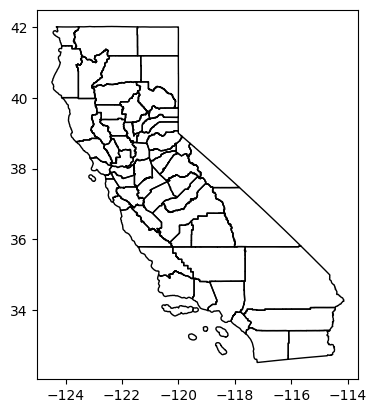

In [32]:
gdf = gpd.read_file("/content/CA_Counties/CA_Counties_TIGER2016.shp")
gdf = gdf.to_crs("EPSG:4326")
gdf.plot(color="none", edgecolor='black')

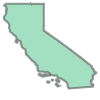

In [33]:
region = gdf.unary_union
region

### Checking if a sensor is within the region

In [38]:
data.keys()

dict_keys(['api_version', 'time_stamp', 'data_time_stamp', 'max_age', 'firmware_default_version', 'fields', 'data'])

In [46]:
data['max_age']

604800

In [51]:
7*24*3600  # only getting the sensors which reported data within last 7 days.

604800

In [42]:
df = pd.DataFrame(data['data'], columns=data['fields'])
df.head(2)

sensor_index   latitude   longitude
0           195  41.060000 -124.128840
1           417  33.716675 -118.309906

In [44]:
def check_within(lat, lon):
    point = Point(lon, lat)
    return region.contains(point)

within = Parallel(2)(delayed(check_within)(lat, lon) for lat, lon in tqdm(zip(df['latitude'], df['longitude'])))

0it [00:00, ?it/s]

### Finally, get the number!

In [45]:
print("Number of points within shapefile =", sum(within))

Number of points within shapefile = 10992
